# 1. Imports

In [136]:
from src.configuration import Configuration
from src.fetch_data import DataFetcher
from aggregate_data import DataAggregator
from src.dim import Dims
from src.facts import Facts
from src.dicts import Dicts
import pandas as pd
import numpy as np 
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text



# 2. Variables

In [16]:
config = Configuration('src/config.cfg')
fetcher = DataFetcher(config)
DATAAGGREGATOR = DataAggregator(config, fetcher)
DIMS = Dims(config, fetcher)
DICTS = Dicts(config, fetcher)
FACTS = Facts(config, fetcher)

pd.set_option('display.max_columns', None)

# 3. Data

## 3.1 Driver related data

In [17]:
driver_last_5_races_result = DATAAGGREGATOR.get_last_races_result(5,"Race", "position")
time.sleep(5)
driver_last_5_quali_result = DATAAGGREGATOR.get_last_races_result(5,"Qualifying", "position")
time.sleep(5)
driver_last_5_avg_race_position = DATAAGGREGATOR.get_last_races_result(5, "Race", "avg")
time.sleep(5)
driver_last_5_std_race_position = DATAAGGREGATOR.get_last_races_result(5, "Race", "std")
time.sleep(5)
driver_last_5_avg_quali_position = DATAAGGREGATOR.get_last_races_result(5, "Qualifying", "avg")
time.sleep(5)
driver_last_5_std_quali_position = DATAAGGREGATOR.get_last_races_result(5, "Qualifying", "std")
time.sleep(5)
driver_points_gathered = DATAAGGREGATOR.get_racer_team_points("driver")
time.sleep(10)
driver_gap_to_teammate = DATAAGGREGATOR.calculate_gap_to_teammate()
time.sleep(5)
driver_gap_to_leader = DATAAGGREGATOR.calculate_gap_to_leader()
dict_world_champions = DICTS.dict_world_champions()
time.sleep(10)
pit_stops_efficiency = DATAAGGREGATOR.calculate_pit_stop_efficiency()
time.sleep(10)
driver_race_wins_total = DATAAGGREGATOR.calculate_total_wins("Race")
time.sleep(10)
driver_quali_wins_total = DATAAGGREGATOR.calculate_total_wins("Qualifying")
time.sleep(10)

/Users/grzegorznaporowski/Desktop/Portfolio/F1/aggregate_data.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered["points_gap_to_teammate"] = merged_filtered["points_gained"] - merged_filtered["points_gained_other"]


## 3.2 Team related data

In [18]:
team_points_gathered = DATAAGGREGATOR.get_racer_team_points("team")
time.sleep(5)
team_gap_to_leader = DATAAGGREGATOR.calculate_gap_to_best_team()
time.sleep(10)

## 3.3 Session Related Data

In [19]:
dim_session = DIMS.dim_sessions()
dim_session_race = dim_session[dim_session["session_name"]=="Race"]
needed_cols = ["key", "location", "year", "is_current_season","country_name", "date_start", "session_key"]
dim_session_race = dim_session_race[needed_cols]
race_sequence = DATAAGGREGATOR.calculate_race_sequence_number()

In [20]:
needed_cols = ["driver_number","key","number_of_laps","dnf","dns","dsq","duration"]
fact_session_result = FACTS.fact_session_results()
race_duration = fact_session_result.merge(
    dim_session_race,
    on = "session_key",
    how="inner"
)

race_duration = race_duration[needed_cols]
race_duration["duration"] = race_duration["duration"].fillna(9999)

/var/folders/rd/z4g97_m5135b3yksvpxnxw1m0000gn/T/ipykernel_3350/1971916267.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  race_duration["duration"] = race_duration["duration"].fillna(9999)


## 3.4 Weather Data

In [21]:
dim_session_quali = dim_session[dim_session["session_name"]=="Qualifying"]
needed_cols = ["key", "location", "year", "is_current_season","country_name", "date_start", "session_key"]
dim_session_quali = dim_session_quali[needed_cols]
dim_weather_quali = DIMS.dim_weather(race_type="Qualifying")

### 3.5 Qualification Weather

In [22]:
quali_weather = dim_weather_quali.merge(
    dim_session_quali,
    on="session_key",
    how="inner"
)
cols_quali = [col for col in quali_weather.columns if "quali" in col or col == "key"]
quali_weather = quali_weather[cols_quali]

## 3.5 Joined Data

In [23]:
df = (
    dim_session
    .merge(driver_last_5_races_result, on="key", how="inner")
    .merge(driver_last_5_quali_result, on=["key", "driver_number"], how="inner", suffixes=["_race", "_quali"])
    .merge(driver_last_5_avg_race_position, on=["driver_number", "key"])
    .merge(driver_last_5_std_race_position, on=["driver_number", "key"])
    .merge(driver_last_5_avg_quali_position, on=["driver_number", "key"])
    .merge(driver_last_5_std_quali_position, on=["driver_number", "key"])
    .merge(driver_points_gathered[["driver_number", "key", "points_gained"]], on=["driver_number", "key"])
    .merge(driver_gap_to_teammate, on=["driver_number", "key"])
    .merge(driver_gap_to_leader, on=["driver_number", "key"])
    .merge(driver_race_wins_total, on = ["driver_number", "key"])
    .merge(driver_quali_wins_total, on = ['driver_number', 'key'])
    .merge(team_points_gathered, on=["driver_number", "key"])
    .merge(team_gap_to_leader, on=["driver_number", "key"])
    .merge(dict_world_champions,on="driver_number",how="left")
    .fillna({"titles_count": 0})
    .assign(world_champion=lambda x: x["titles_count"].astype(int))
    .merge(race_duration, on=["driver_number","key"])
    .merge(pit_stops_efficiency, on=["driver_number","key"])
    .merge(quali_weather, on="key")
    .merge(race_sequence, on="key")
)


In [24]:
df.head()

,session_key,location,date_start,date_end,session_name,country_code,country_name,year,is_current_season,key,driver_number,position_race,last_race_pos_1,last_race_pos_2,last_race_pos_3,last_race_pos_4,last_race_pos_5,position_quali,last_qualifying_pos_1,last_qualifying_pos_2,last_qualifying_pos_3,last_qualifying_pos_4,last_qualifying_pos_5,avg_last_5_race,std_last_5_race,avg_last_5_qualifying,std_last_5_qualifying,points_gained,points_gap_to_teammate,gap_to_leader,wins_before_session_Race,wins_before_session_Qualifying,team_name,team_points_gained,gap_to_best_team,titles_count,world_champion,number_of_laps,dnf,dns,dsq,duration,last_5_races_median_pit_stop_time,wind_direction_qualifying_avg,wind_speed_qualifying_avg,has_rainfall_qualifying,track_temperature_qualifying_avg,air_temperature_qualifying_avg,humidity_qualifying_avg,pressure_qualifying_avg,race_number
0,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,1,1.0,2.0,1.0,2.0,1.0,1.0,1.0,15.0,1.0,2.0,9.0,1.0,1.4,0.489898,5.6,5.571355,145.0,36.0,0.0,4,3,Red Bull Racing,254.0,0.0,4.0,4,66.0,False,False,False,5277.940,23.3,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
1,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,2,20.0,16.0,16.0,16.0,20.0,18.0,20.0,21.0,18.0,15.0,20.0,16.0,17.2,1.600000,18.0,2.280351,0.0,-1.0,145.0,0,0,Williams,1.0,253.0,0.0,0,65.0,False,False,False,9999.000,23.3,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
2,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,4,17.0,17.0,6.0,9.0,17.0,9.0,3.0,19.0,13.0,7.0,16.0,10.0,11.6,4.543127,13.0,4.242641,12.0,7.0,133.0,0,0,McLaren,17.0,237.0,0.0,0,65.0,False,False,False,9999.000,23.3,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
3,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,10,10.0,9.0,13.0,14.0,8.0,7.0,4.0,10.0,9.0,19.0,5.0,7.0,10.2,2.785678,10.0,4.816638,15.0,-10.0,130.0,0,0,Alpine,40.0,214.0,0.0,0,66.0,False,False,False,5351.470,23.3,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
4,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,11,4.0,1.0,5.0,1.0,2.0,16.0,11.0,1.0,21.0,3.0,1.0,20.0,5.0,5.692100,9.2,9.260670,109.0,-36.0,36.0,2,2,Red Bull Racing,254.0,0.0,0.0,0,66.0,False,False,False,5313.752,23.3,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7


# 4. Creating train and test datasets

In [88]:
df = df.sort_values(by=['date_start', 'driver_number'], ascending=True).reset_index(drop=True)
df['target'] = [1 if x == 1 else 0 for x in df['position_race']]

In [89]:
train_size = 0.7
train_loc_cutoff = int(df.shape[0] * train_size)
train_date_cutoff = df.iloc[train_loc_cutoff]['date_start']
train_df = df[df['date_start'] < train_date_cutoff].reset_index(drop=True)
test_df = df[df['date_start'] >= train_date_cutoff].reset_index(drop=True)

In [90]:
unnecessary_columns = ['session_key', 'date_start','date_end','country_code','country_name','key', 'position_race']
train_df = train_df.drop(columns=unnecessary_columns)
test_df = test_df.drop(columns=unnecessary_columns)

In [91]:
y_train = train_df['target']
X_train = train_df.drop("target", axis=1)
y_test = test_df['target']
X_test = test_df.drop("target", axis=1)

In [104]:
X_train['year'] = X_train['year'].astype('string')
X_train['is_current_season'] = X_train['is_current_season'].astype('string')
X_train['driver_number'] = X_train['driver_number'].astype('string')
X_test['year'] = X_test['year'].astype('string')
X_test['is_current_season'] = X_test['is_current_season'].astype('string')
X_test['driver_number'] = X_test['driver_number'].astype('string')

# 5. Drivers Similarities

In [105]:
driver_related_columns = X_train.columns[4:30]

In [106]:
driver_df = X_train[driver_related_columns]

In [107]:
no_mean_cols = ["titles_count", "world_champion"]

cols_to_mean = [
    col for col in driver_df.columns 
    if col not in no_mean_cols 
    and col not in ["driver_number", "team_name"]
]

driver_df_agg = driver_df.groupby("driver_number").agg(
    {**{col: "mean" for col in cols_to_mean},
     **{col: "max" for col in no_mean_cols},   
     "team_name": lambda x: x.mode().iloc[0]}  
).reset_index()


In [108]:
cluster_driver_features = [c for c in driver_related_columns[1:] if c != 'team_name']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

remainder_pipe = make_pipeline(
    SimpleImputer(strategy='median')
)

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ("num", num_pipeline, cluster_driver_features)
],
remainder=remainder_pipe)



preprocessed_driver_data = pd.DataFrame(preprocessing.fit_transform(driver_df_agg), columns=preprocessing.get_feature_names_out())

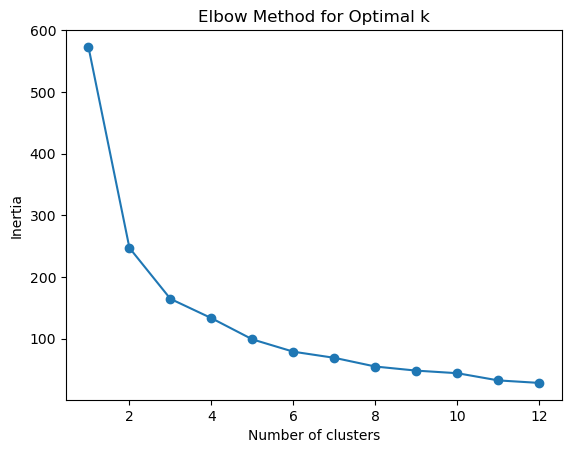

In [109]:
cluster_cols = [col for col in preprocessed_driver_data.columns if "remainder__" not in col]

n_clusters = 12
inertias = []
for cluster in range(1,n_clusters+1):
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(preprocessed_driver_data[cluster_cols])
    inertias.append(kmeans.inertia_)


plt.plot([i for i in range(1,n_clusters+1)], inertias, marker='o')
plt.xlabel("Number of clusters");
plt.ylabel("Inertia");
plt.title("Elbow Method for Optimal k");

In [110]:
best_n_clusters = 3
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
preprocessed_driver_data['cluster'] = best_kmeans.fit_predict(preprocessed_driver_data[cluster_cols])

In [111]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(preprocessed_driver_data[cluster_cols])
preprocessed_driver_data['pca_one'] = pca_components[:,0]
preprocessed_driver_data['pca_two'] = pca_components[:,1]

In [112]:
pca.explained_variance_ratio_

array([0.68078045, 0.12239397])

In [113]:
dim_driver_number = DIMS.dim_driver_number()
dim_driver_number = dim_driver_number.sort_values(by='session_key', ascending=False).groupby('driver_number').agg(
    full_name = ('full_name', 'first')
).reset_index(drop=False)

In [114]:
preprocessed_driver_data = preprocessed_driver_data.merge(
    dim_driver_number,
    left_on = 'remainder__driver_number',
    right_on = 'driver_number',
    how = 'inner'
)

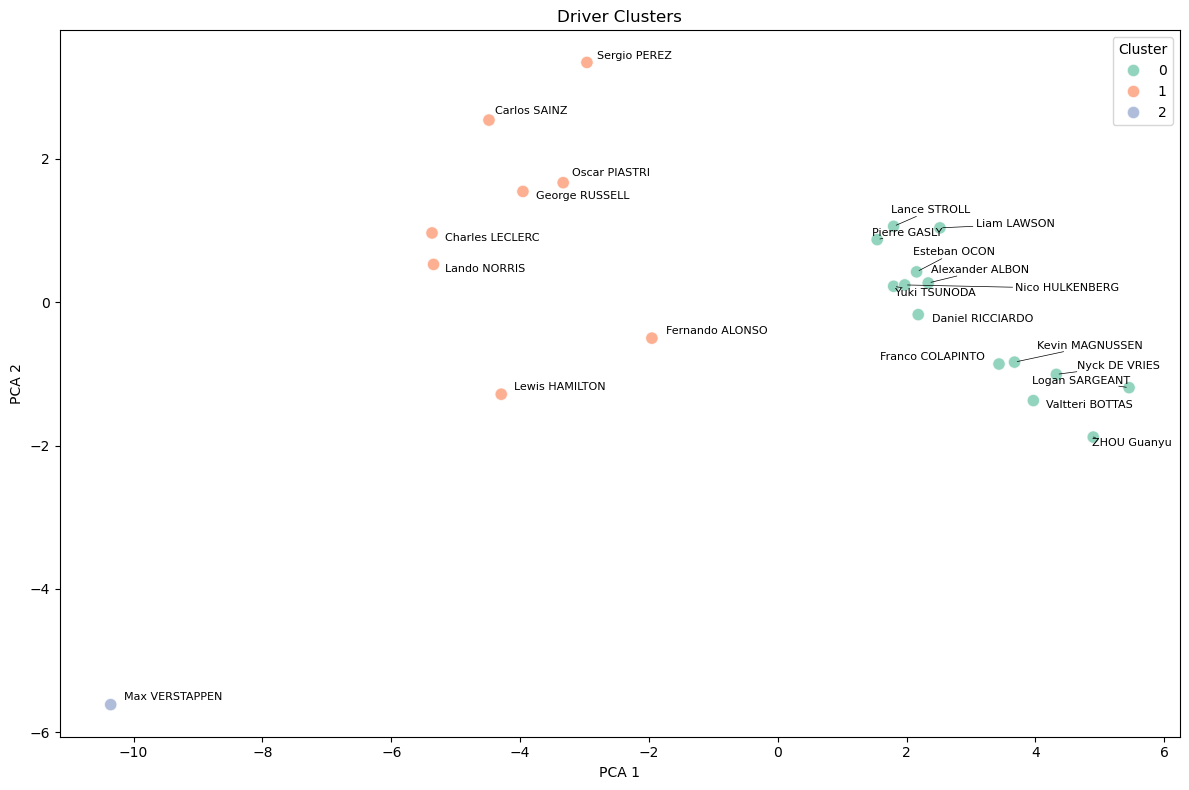

In [58]:

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=preprocessed_driver_data,
    x='pca_one',
    y='pca_two',
    hue='cluster',
    palette='Set2',
    alpha=0.7,
    s=80
)

texts = []
for _, row in preprocessed_driver_data.iterrows():
    texts.append(
        plt.text(
            row['pca_one'],
            row['pca_two'],
            str(row['full_name']),
            fontsize=8
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', lw=0.5)
)

plt.title("Driver Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# 6. Custom KMeans Transformer

In [115]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=None):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self
    
    def transform(self, X):
        return self.kmeans_.predict(X).reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        return ["driver_cluster"]

In [116]:
cluster_driver_features = [c for c in driver_related_columns[1:] if c != 'team_name']


remainder_pipe = make_pipeline(
    SimpleImputer(strategy='median')
)

cluster_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    ClusterSimilarity()
)

preprocessing = ColumnTransformer([
    ("cluster", cluster_pipeline, cluster_driver_features),
    ("driver",  remainder_pipe, ["driver_number"])
],
remainder='drop')



cluster_driver_data = pd.DataFrame(preprocessing.fit_transform(driver_df_agg), columns=preprocessing.get_feature_names_out())

# 7. Creating Data Pipeline

In [118]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

obj_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

cluster_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    ClusterSimilarity()
)

remainder_pipe = make_pipeline(
    SimpleImputer(strategy='median')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
    ("obj", obj_pipeline, make_column_selector(dtype_include=object)),
    ("cluster", cluster_pipeline, cluster_driver_features)
],
remainder=remainder_pipe
)

In [119]:
preprocessing

,transformers,"[('num', ...), ('obj', ...), ...]"
,remainder,Pipeline(step...y='median'))])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [126]:
preprocessing.fit(X_train)
preprocessed_train_data = pd.DataFrame(preprocessing.transform(X_train), columns=preprocessing.get_feature_names_out())
preprocessed_test_data = pd.DataFrame(preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

# 8. Data Modelling

## 8.1 Random Forest Model

# TODO: START BUILDING MODELS